# Matched Distribution and RFKO Tracking
(using Xtrack instead of PyBT)

- Start at resonance
- Add a quadrupole to move away from resonance
- Match a distribution
- Track and collapse quad over a few hundred turns
- You should see the ellipse transform into a triangular shape
- Then start RFKO

``dQ = Beta(at quad)*integrated_strength [m]*[m^-1]``


REFERNCE SIMPLE CASE - constantly on, simple noise
- [ ] No momentum spread
- [ ] Simpler functions
- [ ] Use RMS voltage = gaussian distribution, similar effect
- [ ] Look at sextupoles
- [ ] More particles?

- remove bumps

- [ ] Put septum in to remove particles - will remove "weirdness"

In [1]:
import xtrack as xt
import xpart as xp
import xobjects as xo

import pybt

import matplotlib.pyplot as plt

import json
from numpy import random
import random
import numpy as np

from cpymad.madx import Madx

import scipy as sp

from progressbar import progressbar

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# Constants

In [2]:
REL_GAMMA = 25.598474067
REL_BETA = np.sqrt(1-REL_GAMMA**(-2))

exn = 1.5e-6
eyn = 1.5e-6
ex = exn/(REL_BETA*REL_GAMMA)
ey = eyn/(REL_BETA*REL_GAMMA)

p = 24 # beam momentum (GeV/c)
momentum = 24 # beam momentum (GeV/c)
Brho = 24*3.3356

PS_radius = 70.079
DPP_FACTOR = 1e-3

N_PART = int( 2e3 )

## QUAD COLLAPSE

TUNE_TARGET = 0.330
#TUNE_TARGET = 1/3
CHROMATICITY_TARGET = -0.5
N_TURN = int( 5e2 )

DETUNE_QUAD_KNL1 = -0.04
# DETUNE_QUAD_KNL1 = 0

## rifko

SEPTA = True
EXCITER_SAMPLING_FREQ = 1e6

CHIRP_START = .3
CHIRP_STOP = .35

CHIRP_INTERVAL = 0.001

N_TURN_CHIRP = int( 6e3 )

SEPTA_X_MM = -60

RFKO_STRENGTH = .5

In [3]:
import os
DIR = f"prelim_results/rfko_quadcollapse_Q{round(TUNE_TARGET, 5)}_S{SEPTA_X_MM}_T{N_TURN_CHIRP}"
os.makedirs(DIR, exist_ok=True)
print(f"Directory: {DIR}")

Directory: prelim_results/rfko_quadcollapse_Q0.33_S-60_T6000


# Load PS at East Extraction

In [4]:
mad = Madx(stdout=True)

PS_REPO = "../../../../models/acc-models-ps/"

mad.call(PS_REPO+"ps_mu.seq")
mad.call(PS_REPO+"ps_ss.seq")
mad.call(PS_REPO+"scenarios/east/4_slow_extraction/ps_se_east.str")

mad.command.beam(
    particle="PROTON",
    pc = p,
    ex = ex,
    ey = ey
)
mad.input(f"BRHO      := BEAM->PC * 3.3356;")
mad.use(sequence="PS")

# turn off 23 for ions
mad.input("kPEBSW23 := 0;")

mad.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,KEYWORD,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APERTYPE,APER_1,APER_2,APER_3,APER_4,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')
mad.input('savebeta, label=bumped23, place = PR.BPM23;')


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.08.01  (64 bit, Darwin)      +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2022.02.25               +
  + Execution date: 2023.04.03 16:15:13      +
  ++++++++++++++++++++++++++++++++++++++++++++
/**********************************************************************************

*

* Elements description and sequence file for each PS main unit (MU).

*

* 07/10/2020 - Alexander Huschauer

************************************************************************************/



/************************************************************************************

*

*         DEFINITION OF FOCUSING AND DEFOCUSING HALF-UNITS OF THE MU               

*

*************************************************************************************/



/************************************************************************************

*        							 F HALF-UNITS     					            

***********************

True

# Set PFWs, Cycle & Flatten

In [5]:
def tune_match(Qx,Qxp,Qy,Qyp,p,ex,ey):
    
    with open('tempfile', 'w') as f:
        madx = Madx(stdout=f,stderr=f)
        madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)

    # Call latice files
    madx.call(PS_REPO+"ps_mu.seq")
    madx.call(PS_REPO+"ps_ss.seq")
    madx.call(PS_REPO+"scenarios/east/4_slow_extraction/ps_se_east.str")

    madx.command.beam(particle='PROTON',
                      pc=p,
                      ex=ex,
                      ey=ey)
    madx.input('BRHO      := BEAM->PC * 3.3356;')

    madx.use(sequence = "PS")
    madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,KEYWORD,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APERTYPE,APER_1,APER_2,APER_3,APER_4,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')
    madx.input('savebeta, label=bumped23, place = PR.BPM23;')
    twiss_initial = madx.twiss().dframe()
    len_ps = twiss_initial.s[-1]

    ### Cycle sequence, changing starting point and adding markers at around the magnet 62
    madx.input('SEQEDIT, sequence=PS;')
    madx.input('FLATTEN;')
    madx.command.install(element = 'marker_ss62_end', class_='MARKER', at=0, from_='SS62$END')
    madx.command.install(element = 'marker_ss63_start', class_='MARKER', at=0, from_='SS63$START')
    madx.input('CYCLE, START=PR.BPM23;') # This will be the place to start the ejection sequence
    madx.input('FLATTEN;')
    madx.input('ENDEDIT;')
    madx.use(sequence='ps')
    madx.select(flag='makethin', class_='rbend', slice_=4)
    madx.select(flag='makethin', class_='quadrupole', slice_=4)
    madx.select(flag='makethin', class_='sbend', slice_=4)
    madx.select(flag='makethin', class_='sextupole', slice_=2)
    madx.makethin(sequence='ps')
    madx.use(sequence='ps')

    twiss_cycled = madx.twiss().dframe()
    
    madx.input('''
    ptc_twiss_macro(order, dp, slice_flag): macro = {
      ptc_create_universe;
      ptc_create_layout, time=false, model=2, exact=true, method=6, nst=3;
      IF (slice_flag == 1){
        select, flag=ptc_twiss, clear;
        select, flag=ptc_twiss, column=name,keyword,s,l,x,px,beta11,beta22,disp1,k1l;
        ptc_twiss, closed_orbit, icase=56, no=order, deltap=dp, table=ptc_twiss, summary_table=ptc_twiss_summary, slice_magnets=true;
      }
      ELSE{
        select, flag=ptc_twiss, clear;
        select, flag=ptc_twiss, column=name,keyword,s,x,px,beta11,alfa11,beta22,alfa22,disp1,disp2,mu1,mu2,energy,l,angle,K1L,K2L,K3L,HKICK,SLOT_ID;    
        ptc_twiss, closed_orbit, icase=56, no=order, deltap=dp, table=ptc_twiss, summary_table=ptc_twiss_summary, normal;
      }
      ptc_end;
    };

    ''')
    
    #/**********************************************************************************
    # *                        Matching using the PFW
    #***********************************************************************************/
    madx.input("Qx   := "+str(Qx)+"; !Horizontal Tune")
    madx.input("Qxp  := "+str(Qxp)+"; !Horizontal Chromaticity")

    madx.input("Qy   := "+str(Qy)+"; !Vertical Tune")
    madx.input("Qyp  := "+str(Qyp)+"; !Vertical Chromaticity")

    madx.input('''
    use, sequence=PS;
    match, use_macro;
            vary, name = k1prpfwf;
            vary, name = k1prpfwd;
            vary, name = k2prpfwf;
            vary, name = k2prpfwd;
            use_macro, name = ptc_twiss_macro(2,0,0);
            constraint, expr = table(ptc_twiss_summary,Q1)  = Qx;
            constraint, expr = table(ptc_twiss_summary,Q2)  = Qy;
            constraint, expr = table(ptc_twiss_summary,DQ1) = Qxp;
            constraint, expr = table(ptc_twiss_summary,DQ2) = Qyp;
    jacobian,calls=50000,bisec=3;
    ENDMATCH;
    ''')
    
    madx.use(sequence="PS")
    twiss_tune_matching = madx.twiss().dframe() # Needed to refresh the tune values
    madx.input('qx = table(SUMM, Q1);')
    madx.input('qy = table(SUMM, Q2);')
    madx.input('qxp = table(SUMM, DQ1);')
    madx.input('qyp = table(SUMM, DQ2);')
    
    tune_info_dict = {"Qx": madx.globals["qx"], "Qy": madx.globals["qy"], "Qxp": madx.globals["qxp"], "Qyp": madx.globals["qyp"]}
    pfw_dict = {"k1prpfwf": madx.globals["k1prpfwf"], "k1prpfwd": madx.globals["k1prpfwd"], "k2prpfwf": madx.globals["k2prpfwf"], "k2prpfwd": madx.globals["k2prpfwd"]}

    print (f"H-tune: {round(tune_info_dict['Qx'],3)}, H-Chroma: {round(tune_info_dict['Qxp'],3)}\nV-Tune: {round(tune_info_dict['Qy'],3)}, V-Chroma: {round(tune_info_dict['Qyp'],3)}")
    print (f"")
    print (f"PFW settings: \n  k1prpfwf: {round(pfw_dict['k1prpfwf'],6)}\n  k1prpfwd: {round(pfw_dict['k1prpfwd'],6)}\n  k2prpfwf: {round(pfw_dict['k2prpfwf'],6)}\n  k2prpfwd: {round(pfw_dict['k2prpfwd'],6)}")

    madx.quit()
    
    return pfw_dict, tune_info_dict

In [6]:
pfw_dict_on_resonance, tune_info_on_resonance = tune_match(Qx=TUNE_TARGET,Qxp=CHROMATICITY_TARGET,Qy=0.3,Qyp=-0.242, p=p, ex=ex, ey=ey) # Chroma from measurements on 12.11.21 

H-tune: 6.33, H-Chroma: -0.5
V-Tune: 6.3, V-Chroma: -0.242

PFW settings: 
  k1prpfwf: 0.000235
  k1prpfwd: -0.000401
  k2prpfwf: 0.009128
  k2prpfwd: -0.019919


In [7]:
mad.input("k1prpfwf = "+str(pfw_dict_on_resonance["k1prpfwf"])+";")
mad.input("k1prpfwd = "+str(pfw_dict_on_resonance["k1prpfwd"])+";")
mad.input("k2prpfwf = "+str(pfw_dict_on_resonance["k2prpfwf"])+";")
mad.input("k2prpfwd = "+str(pfw_dict_on_resonance["k2prpfwd"])+";")
mad.use(sequence="PS")
mad.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,KEYWORD,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APERTYPE,APER_1,APER_2,APER_3,APER_4,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')

##### INITIAL ##

twiss_initial = mad.twiss().dframe()
len_ps = twiss_initial.s[-1]

mad.input('SEQEDIT, sequence=PS;')
mad.input('FLATTEN;')
mad.command.install(element = 'marker_ss62_end', class_='MARKER', at=0, from_='SS62$END')
mad.command.install(element = 'marker_ss63_start', class_='MARKER', at=0, from_='SS63$START')
mad.command.install(element = 'marker_seh23', class_='MARKER', at=-0.4, from_='PE.SEH23')
mad.input('CYCLE, START=PR.BPM23;') # This will be the place to start the ejection sequence
mad.input('FLATTEN;')
mad.input('ENDEDIT;')
mad.use(sequence = "PS")

# CODIMD

#mad.input("kprqse = 0.1379634524;")

#mad.input("kprxse = 1.278381613;")

###### Rebecca's changes

# mad.input('kprqse = 0.13739;')
# mad.input('kprxse = 1.836;')
# mad.input('kprodn = -6.0;')

##### Initial Conditions

initial_conditions = (-0.07, (-0.00135 + -0.0015)/2)
# mad.input('kpebsw57 = 0.0;')
mad.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,KEYWORD,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APERTYPE,APER_1,APER_2,APER_3,APER_4,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')
twiss_cycled_beta = mad.twiss(x=initial_conditions[0], px=initial_conditions[1], beta0="bumped23").dframe()
##### CYCLED ##
twiss_cycled = mad.twiss().dframe()


++++++ info: k1prpfwf redefined
++++++ info: k1prpfwd redefined
++++++ info: k2prpfwf redefined
++++++ info: k2prpfwd redefined
enter Twiss module
  
iteration:   1 error:   2.464841E-04 deltap:   0.000000E+00
orbit:   1.942832E-03  1.024752E-04  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
  
iteration:   2 error:   2.483275E-05 deltap:   0.000000E+00
orbit:   1.934866E-03  1.030930E-04  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
  
iteration:   3 error:   1.016520E-09 deltap:   0.000000E+00
orbit:   1.934866E-03  1.030929E-04  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: summ

            length             orbit5               alfa            gammatr 
          628.3185                 -0      0.02576557213        6.229886074 

                q1                dq1            betxmax              dxmax 
       6.328317887       0.5921259005        32.50906467        4.439086995 

             dxrms             xcomax             xcorms 

###
---

In [8]:
twiss_before_makethin = mad.twiss().dframe()

# Makethin
QUAD_SLICE = 4
mad.use(sequence='ps')
mad.select(flag='makethin', class_='rbend', slice_=QUAD_SLICE)
mad.select(flag='makethin', class_='quadrupole', slice_=QUAD_SLICE)
mad.select(flag='makethin', class_='sbend', slice_=QUAD_SLICE)
mad.select(flag='makethin', class_='hkicker', slice_=QUAD_SLICE, thick=False)
mad.select(flag='makethin', class_='sextupole', slice_=2)
mad.makethin(sequence='ps')

twiss_after_makethin = mad.twiss().dframe()

# Convert to Xtrack
mad.use(sequence="PS")
line = xt.Line.from_madx_sequence(
    mad.sequence(),
    )
#line = bare_line.filter_elements(exclude_types_starting_with='Cavity')

enter Twiss module
  
iteration:   1 error:   3.732952E-03 deltap:   0.000000E+00
orbit:   1.417469E-04 -1.361588E-04  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
  
iteration:   2 error:   1.312753E-05 deltap:   0.000000E+00
orbit:   9.854613E-05 -1.385631E-04  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
  
iteration:   3 error:   1.086730E-09 deltap:   0.000000E+00
orbit:   9.854261E-05 -1.385633E-04  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: summ

            length             orbit5               alfa            gammatr 
          628.3185                 -0      0.02576557213        6.229886074 

                q1                dq1            betxmax              dxmax 
       6.328317887       0.5921259005        32.50906467        4.439086995 

             dxrms             xcomax             xcorms                 q2 
       2.716477942      0.02067240235     0.004620479133        6.306550765 

               dq2            

Text(0, 0.5, '$D_x$ [m]')

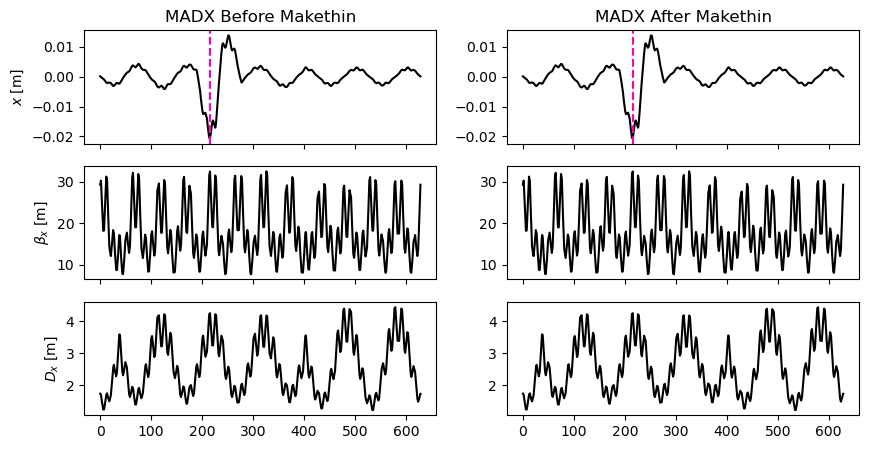

In [9]:
fig, ax = plt.subplots(3, 2, figsize = (10, 5), sharex=True)

madx_smh57_location = twiss_after_makethin.s[np.where(twiss_after_makethin.name == 'pe.smh57:1')[0][0]]

ax[0, 0].plot(twiss_before_makethin.s, twiss_before_makethin.x, 'k', label='MADX')
ax[0, 1].plot(twiss_after_makethin.s, twiss_after_makethin.x, 'k', label='MADX')

ax[1, 0].plot(twiss_before_makethin.s, twiss_before_makethin.betx, 'k', label='MADX')
ax[1, 1].plot(twiss_after_makethin.s, twiss_after_makethin.betx, 'k', label='MADX')

ax[2, 0].plot(twiss_before_makethin.s, twiss_before_makethin.dx, 'k', label='MADX')
ax[2, 1].plot(twiss_after_makethin.s, twiss_after_makethin.dx, 'k', label='MADX')


ax[0, 0].axvline(madx_smh57_location, color='xkcd:bright pink', linestyle='--')
ax[0, 1].axvline(madx_smh57_location, color='xkcd:bright pink', linestyle='--')

ax[0, 0].set_title("MADX Before Makethin")
ax[0, 1].set_title("MADX After Makethin")

ax[0, 0].set_ylabel(r"$x$ [m]")
ax[1, 0].set_ylabel(r"$\beta_x$ [m]")
ax[2, 0].set_ylabel(r"$D_x$ [m]")


In [10]:
KPRQSE_START = 0.1224767158
KPRQSE_END = 0.1379634524

In [11]:
qse_29_ids = [i for i, n in enumerate(line.element_names) if "qse29" in n]
qse_87_ids = [i for i, n in enumerate(line.element_names) if "qse27" in n]

In [12]:
detuning_quad = xt.SimpleThinQuadrupole(
    knl = [0, DETUNE_QUAD_KNL1]
)
line.insert_element(
    element = detuning_quad,
    index = 0,
    name = "DETUNING_QUAD"
)

In [13]:
# Create monitors
ctx = xo.ContextCpu()

line.particle_ref = xp.Particles(
    mass0=xp.PROTON_MASS_EV,
    q0=1,
    p0c=p*sp.constants.c
)

In [14]:
tracker = line.build_tracker()
co_guess = line.build_particles(
    x = initial_conditions[0],
    px = initial_conditions[1],
)
tw = tracker.twiss(method='4d')

generating ./93e9520909524ab58bdb6bd76bbd7c89.c
the current directory is '/Users/ash/cern/dev/md9044/analysis/simulation'


In [15]:
print(f"Dispersion at seh23: {tw['dx'][[i for i, n in enumerate(tw['name']) if 'seh23' in n][0]]}")
print(f"Dispersion at smh57: {tw['dx'][[i for i, n in enumerate(tw['name']) if 'smh57' in n][0]]}")

Dispersion at seh23: 2.6631937413729636
Dispersion at smh57: 6.096947065105012


In [16]:
FREV = 1/tw['T_rev']

In [17]:
x_in_sigmas, px_in_sigmas = xp.generate_2D_gaussian(N_PART)

# TODO: Explain why approximations, or show its the same without approximations

particles = line.build_particles(method='4d',
                    x_norm=x_in_sigmas, # sigmas
                    px_norm=px_in_sigmas, # sigmas
                    nemitt_x=exn, nemitt_y=eyn)

Need second attempt on closed orbit search


Text(0, 0.5, 'px [rad]')

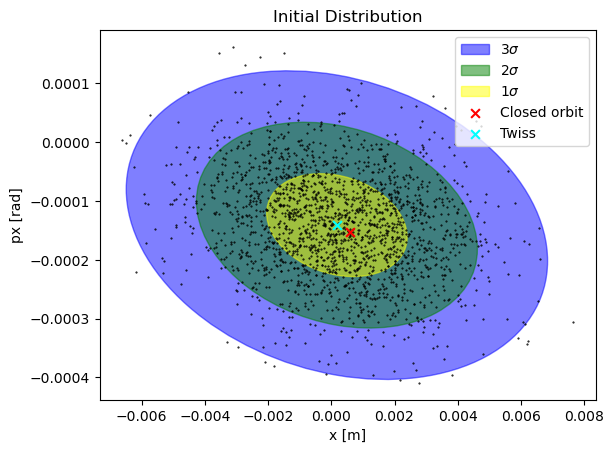

In [18]:
cov = np.cov([particles.x, particles.px])
cov_px = np.cov(particles.px)

w3, h3, r3 = pybt.tools.particles.ellipse_frm_cov(cov, nsig=3)
w2, h2, r2 = pybt.tools.particles.ellipse_frm_cov(cov, nsig=2)
w1, h1, r1 = pybt.tools.particles.ellipse_frm_cov(cov, nsig=1)

co = tracker.find_closed_orbit()
tw = tracker.twiss(method='4d')
parms =  pybt.tools.particles.get_parms(particles.x, particles.px)

fig, ax = plt.subplots()
ax.plot(particles.x, particles.px, 'k.', markersize=1, zorder=3)
from matplotlib.patches import Ellipse, Rectangle
e3 = Ellipse(xy=(tw.x[0], tw.px[0]), width=w3, height=h3, angle=r3, color='blue', alpha=.5, label='3$\sigma$')
e2 = Ellipse(xy=(tw.x[0], tw.px[0]), width=w2, height=h2, angle=r2, color='green', alpha=.5, label='2$\sigma$')
e1 = Ellipse(xy=(tw.x[0], tw.px[0]), width=w1, height=h1, angle=r1, color='yellow', alpha=.5, label='1$\sigma$')

# septa_region = Rectangle((septum.min_x, septum.min_y), septum.max_x-septum.min_x, septum.max_y-septum.min_y, color='red', alpha=.5, label='Septa')
# ax.add_artist(septa_region)

ax.add_artist(e3)
ax.add_artist(e2)
ax.add_artist(e1)

ax.scatter(co.x, co.px, color='red', marker='x', s=40, label='Closed orbit', zorder=4)
ax.scatter(tw.x[0], tw.px[0], color="xkcd:cyan", marker='x', s=40, label="Twiss", zorder=6)

ax.plot()
ax.legend()

ax.set_title("Initial Distribution")
ax.set_xlabel('x [m]')
ax.set_ylabel('px [rad]')


In [19]:
line.unfreeze()
smh57_monitor = xt.ParticlesMonitor(
    _context = ctx,
    num_particles = N_PART,
    start_at_turn = 0,
    stop_at_turn = N_TURN+N_TURN_CHIRP
)
smh61_monitor = xt.ParticlesMonitor(
    _context = ctx,
    num_particles = N_PART,
    start_at_turn = 0,
    stop_at_turn = N_TURN+N_TURN_CHIRP
)
line.insert_element(
    element = smh57_monitor,
    name = 'SMH57_MONITOR',
    index = 'pe.smh57'
)
line.insert_element(
    element = smh61_monitor,
    name = 'SMH61_MONITOR',
    index = 'pe.smh61'
)
septum = xt.LimitRect(
    min_x = SEPTA_X_MM*0.001, # in meters
)
line.insert_element(
    element = septum,
    name = "SEPTUM",
    index = 'pe.smh57'
)
tracker = line.build_tracker()

# Perform MAD twiss
mad_twiss = mad.twiss()
mad_twiss_summ = mad_twiss.summary

# Track
tunes = []
strengths = []

generating ./6751c2d250d34c798cac6e457279db37.c
the current directory is '/Users/ash/cern/dev/md9044/analysis/simulation'
enter Twiss module
  
iteration:   1 error:   3.752033E-03 deltap:   0.000000E+00
orbit:   1.595134E-04 -1.356753E-04  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
  
iteration:   2 error:   1.370998E-05 deltap:   0.000000E+00
orbit:   1.158674E-04 -1.380793E-04  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
  
iteration:   3 error:   9.535690E-10 deltap:   0.000000E+00
orbit:   1.158639E-04 -1.380795E-04  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: summ

            length             orbit5               alfa            gammatr 
          628.3185                 -0      0.02576033785        6.230518971 

                q1                dq1            betxmax              dxmax 
       6.327747675      -0.6610451012        32.69388411        4.459290158 

             dxrms             xcomax             xcorms       

In [20]:
print(f"Tracking for particle {N_TURN} for detuning, {N_TURN_CHIRP} for rfko")

# QUAD COLLAPSE
delta = line['DETUNING_QUAD'].knl[1]/N_TURN
for turn in range(N_TURN):
    # Detuning
    cur_strength = line['DETUNING_QUAD'].knl[1]
    line['DETUNING_QUAD'].knl[1] = cur_strength - delta
    tracker.track(particles)
    tune = tracker.twiss(method='4d')['qx']
    tunes.append(tune)
    strengths.append(line['DETUNING_QUAD'].knl[1])
    print(f"Turn {turn} of {N_TURN}", flush=True)

Tracking for particle 500 for detuning, 6000 for rfko
Turn 0 of 500
Turn 1 of 500
Turn 2 of 500
Turn 3 of 500
Turn 4 of 500
Turn 5 of 500
Turn 6 of 500
Turn 7 of 500
Turn 8 of 500
Turn 9 of 500
Turn 10 of 500
Turn 11 of 500
Turn 12 of 500
Turn 13 of 500
Turn 14 of 500
Turn 15 of 500
Turn 16 of 500
Turn 17 of 500
Turn 18 of 500
Turn 19 of 500
Turn 20 of 500
Turn 21 of 500
Turn 22 of 500
Turn 23 of 500
Turn 24 of 500
Turn 25 of 500
Turn 26 of 500
Turn 27 of 500
Turn 28 of 500
Turn 29 of 500
Turn 30 of 500
Turn 31 of 500
Turn 32 of 500
Turn 33 of 500
Turn 34 of 500
Turn 35 of 500
Turn 36 of 500
Turn 37 of 500
Turn 38 of 500
Turn 39 of 500
Turn 40 of 500
Turn 41 of 500
Turn 42 of 500
Turn 43 of 500
Turn 44 of 500
Turn 45 of 500
Turn 46 of 500
Turn 47 of 500
Turn 48 of 500
Turn 49 of 500
Turn 50 of 500
Turn 51 of 500
Turn 52 of 500
Turn 53 of 500
Turn 54 of 500
Turn 55 of 500
Turn 56 of 500
Turn 57 of 500
Turn 58 of 500
Turn 59 of 500
Turn 60 of 500
Turn 61 of 500
Turn 62 of 500
Turn 63 of 

In [21]:
tune_before = tw['qx']
print(f"Tune before detune: {tune_before}")
tw = tracker.twiss(method='4d')
tune_after = tw['qx']
print(f"Tune after detune: {tune_after}")

Tune before detune: 6.242606330495737
Tune after detune: 6.32775652438359


In [22]:
RAD_TO_MRAD = 1000
M_TO_MM = 1000

# Tracking detune

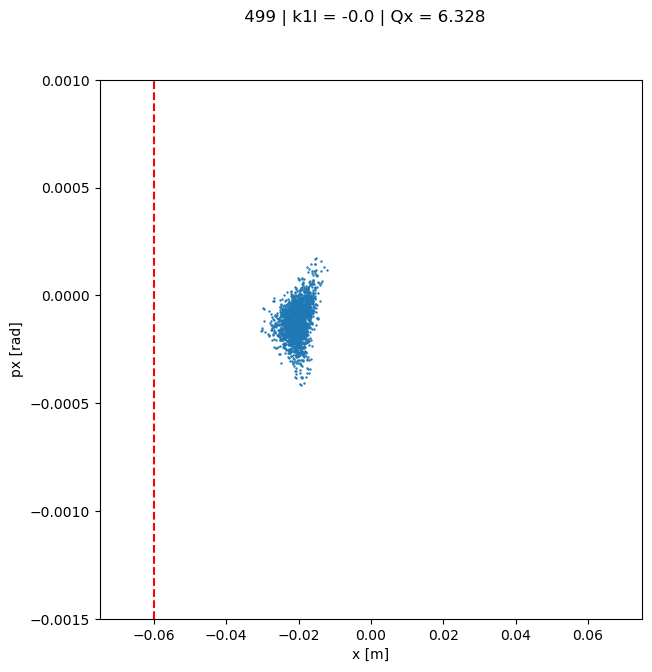

In [23]:
from matplotlib.animation import FuncAnimation, PillowWriter

fig, ax = plt.subplots(figsize=(7, 7), tight_layout=False)

def animate(i):
    ax.clear()
    #ax.set_aspect("equal")
    ax.set_xlabel("x [m]")
    ax.set_ylabel("px [rad]")
    ax.set_xlim(-0.075, 0.075)
    ax.set_ylim(-0.0015, 0.001)
    fig.suptitle(f"{i:>4}")
    fig.suptitle(f"{i:>4} | k1l = {round(strengths[i], 4):>4} | Qx = {round(tunes[i], 3):>4}")
    ax.axvline(SEPTA_X_MM*0.001, color='red', linestyle='--', label='Septa')
    try:
        ax.scatter(smh57_monitor.x.T[i], smh57_monitor.px.T[i], marker='.', s=2)
    except:
        print("fail at", i)
        pass
    return
ani = FuncAnimation(fig, animate, interval=1, blit=False, repeat=False, frames=N_TURN)
ani.save(f"{DIR}/quad_collapse.gif", writer=PillowWriter(fps=30))


Need second attempt on closed orbit search


Text(0, 0.5, 'px [rad]')

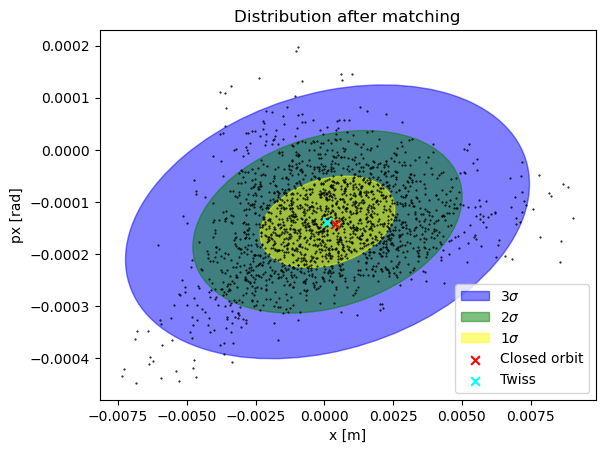

In [24]:
cov = np.cov([particles.x, particles.px])
cov_px = np.cov(particles.px)

w3, h3, r3 = pybt.tools.particles.ellipse_frm_cov(cov, nsig=3)
w2, h2, r2 = pybt.tools.particles.ellipse_frm_cov(cov, nsig=2)
w1, h1, r1 = pybt.tools.particles.ellipse_frm_cov(cov, nsig=1)

co = tracker.find_closed_orbit()
tw = tracker.twiss(method='4d')
parms = pybt.tools.particles.get_parms(particles.x, particles.px)

fig, ax = plt.subplots()
ax.plot(particles.x, particles.px, 'k.', markersize=1, zorder=3)
e3 = Ellipse(xy=(tw.x[0], tw.px[0]), width=w3, height=h3, angle=r3, color='blue', alpha=.5, label='3$\sigma$')
e2 = Ellipse(xy=(tw.x[0], tw.px[0]), width=w2, height=h2, angle=r2, color='green', alpha=.5, label='2$\sigma$')
e1 = Ellipse(xy=(tw.x[0], tw.px[0]), width=w1, height=h1, angle=r1, color='yellow', alpha=.5, label='1$\sigma$')

# septa_region = Rectangle((septum.min_x, septum.min_y), septum.max_x-septum.min_x, septum.max_y-septum.min_y, color='red', alpha=.5, label='Septa')
# ax.add_artist(septa_region)

ax.add_artist(e3)
ax.add_artist(e2)
ax.add_artist(e1)

ax.scatter(co.x, co.px, color='red', marker='x', s=40, label='Closed orbit', zorder=4)
ax.scatter(tw.x[0], tw.px[0], color="xkcd:cyan", marker='x', s=40, label="Twiss", zorder=6)

ax.plot()
ax.legend()

ax.set_title("Distribution after matching")
ax.set_xlabel('x [m]')
ax.set_ylabel('px [rad]')


# RFKO

In [25]:
from signal_gen import generate_chirp

chirp_time, chirp_signal = generate_chirp(
    sampling_freq = EXCITER_SAMPLING_FREQ,
    chirp_start_freq = CHIRP_START*FREV,
    chirp_stop_freq = CHIRP_STOP*FREV,
    chirp_rep_time = CHIRP_INTERVAL,
    turn_freq=FREV
)

In [26]:
mad.use(sequence="PS")
# rfko_line = xt.Line.from_madx_sequence(
#     mad.sequence()
# )
line.unfreeze()
rfko_exciter = xt.Exciter(
    _context = ctx,
    samples = chirp_signal,
    sampling_frequency = EXCITER_SAMPLING_FREQ,
    frev = FREV,
    start_turn = 0,
    knl = [0.00001*RFKO_STRENGTH],
    duration = N_TURN_CHIRP/FREV
)
line.insert_element(
    element = rfko_exciter,
    name = f'EXCITER',
    index = 'pr.kfb97'
)

rfko_line = line.build_tracker()
rfko_line.track(particles, num_turns = N_TURN_CHIRP)

generating ./138494d65969416e969878868883802d.c
the current directory is '/Users/ash/cern/dev/md9044/analysis/simulation'


In [27]:
loss_list = list(zip(particles.at_turn, zip(particles.x, particles.px)))

Text(0, 0.5, 'px [mrad]')

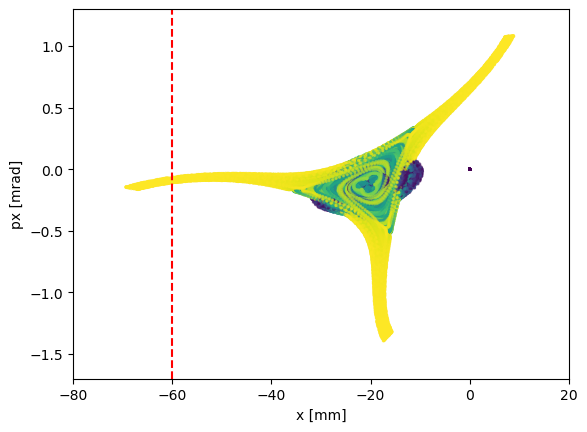

In [28]:
fig, ax = plt.subplots()
for i in range(N_PART):
    ax.scatter(M_TO_MM*smh57_monitor.x[i], RAD_TO_MRAD*smh57_monitor.px[i], cmap='viridis', c=smh57_monitor.at_turn[i], s=2, alpha=.5)
ax.axvline(SEPTA_X_MM, color='red', linestyle='--', label='Septa')
ax.set_xlim(-80, 20)
ax.set_ylim(-1.7, 1.3)
ax.set_xlabel("x [mm]")
ax.set_ylabel("px [mrad]")

In [29]:
cts_dict = dict(zip(*np.unique(particles.at_turn, return_counts=True)))

In [30]:
turn_counts = []
turn_culm = []
for trn in range(N_TURN_CHIRP+N_TURN):
    try:
        turn_counts.append(cts_dict[trn])
        turn_culm.append(turn_culm[-1] + cts_dict[trn])
    except KeyError:
        turn_counts.append(0)
        try:
            turn_culm.append(turn_culm[-1])
        except IndexError:
            turn_culm.append(0)

(0.0, 2000.0)

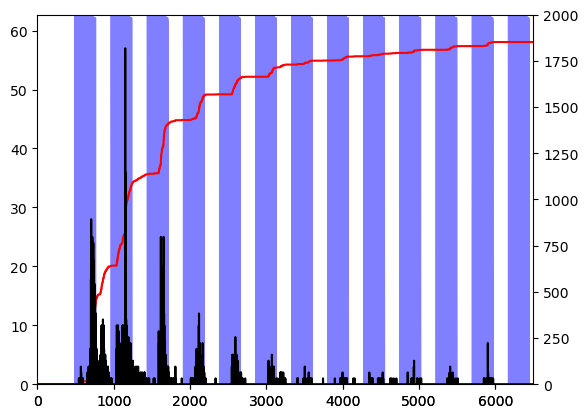

In [31]:
from collections import Counter
counter_turns, counter_counts = list(zip(*sorted(Counter(particles.at_turn).items())))
counter_turns = np.array(counter_turns)
counter_counts = np.array(counter_counts)
counter_culm = np.cumsum(counter_counts)

fig = plt.figure()
ax3 = fig.add_subplot(111, label='3')
ax2 = fig.add_subplot(111, label='2', frame_on=False)
ax = fig.add_subplot(111, label='1', frame_on=False)


chirp_duration = N_TURN_CHIRP/FREV
samples_for_chirp = chirp_duration*EXCITER_SAMPLING_FREQ
samples_to_extend = int(samples_for_chirp)
quad_collapse_duration = N_TURN/FREV
samples_for_quad_collapse = quad_collapse_duration*EXCITER_SAMPLING_FREQ
quad_collapse_to_extend = int(samples_for_quad_collapse)
ax3.plot(np.linspace(0, chirp_duration+quad_collapse_duration, samples_to_extend+quad_collapse_to_extend), np.pad(np.pad(chirp_signal, pad_width=(0, samples_to_extend-len(chirp_signal)), mode='wrap'), pad_width=(quad_collapse_to_extend, 0), mode='constant', constant_values=0), label='Chirp', color='blue', alpha=.5)
ax3.set_xlim(0, chirp_duration+quad_collapse_duration)
ax3.set_ylim(0, 1)
ax3.get_xaxis().set_visible(False)
ax3.get_yaxis().set_visible(False)


ax.plot(range(N_TURN+N_TURN_CHIRP), turn_counts, 'k-', zorder=1)
ax.set_ylim(0, max(turn_counts)*1.1)
ax.set_xlim(0, N_TURN+N_TURN_CHIRP)


ax2.plot(range(N_TURN+N_TURN_CHIRP), turn_culm, 'r-', zorder=1)
ax2.yaxis.tick_right()
ax2.set_xlim(0, N_TURN+N_TURN_CHIRP)
ax2.set_ylim(0, N_PART)




(0.0, 1.0)

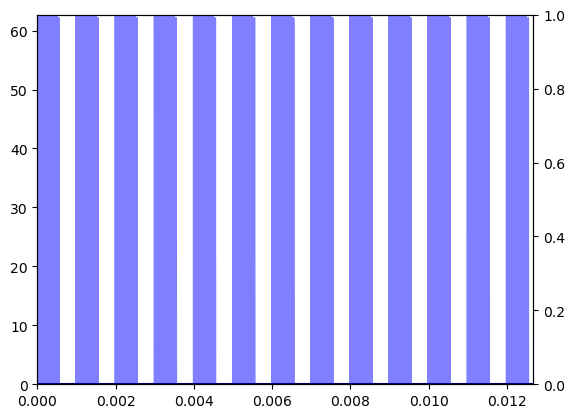

In [32]:
from collections import Counter
counter_turns, counter_counts = list(zip(*sorted(Counter(particles.at_turn).items())))
counter_turns = np.array(counter_turns)
counter_counts = np.array(counter_counts)
counter_culm = np.cumsum(counter_counts)

fig = plt.figure()
ax = fig.add_subplot(111, label='1')



ax.plot(range(N_TURN+N_TURN_CHIRP), turn_counts, 'k-')
ax.set_ylim(0, max(turn_counts)*1.1)
ax.set_xlim(0, N_TURN+N_TURN_CHIRP)


# ax2 = ax.twinx()
# ax2.plot(range(N_TURN+N_TURN_CHIRP), turn_culm, 'r-')
# ax2.set_xlim(0, N_TURN+N_TURN_CHIRP)
# ax2.set_ylim(0, N_PART)

ax3 = ax.twinx()
chirp_duration = N_TURN_CHIRP/FREV
samples_for_chirp = chirp_duration*EXCITER_SAMPLING_FREQ
samples_to_extend = int(samples_for_chirp)
ax3.plot(np.linspace(0, chirp_duration, samples_to_extend), np.pad(chirp_signal, pad_width=(0, samples_to_extend-len(chirp_signal)), mode='wrap'), 'b', zorder=1, alpha=.5)
ax3.set_xlim(0, chirp_duration)
ax3.set_ylim(0, 1)

/var/folders/q6/pm7mcbgn2m3cs67hqk4fvgf40000gn/T/ipykernel_45707/3751030460.py:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  try: loss_x, loss_y = list(zip(*np.array(loss_list)[np.where(np.logical_and(turn <= np.array(loss_list)[:,0], np.array(loss_list)[:,0] <= turn+2))[0]][:,1]))
/var/folders/q6/pm7mcbgn2m3cs67hqk4fvgf40000gn/T/ipykernel_45707/3751030460.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  try: lossf1_x, lossf1_y = list(zip(*np.array(loss_list)[np.where(np.logical_and(turn-3 <= np.array(loss_list)[:,0], np.array(loss_list)[:,0]

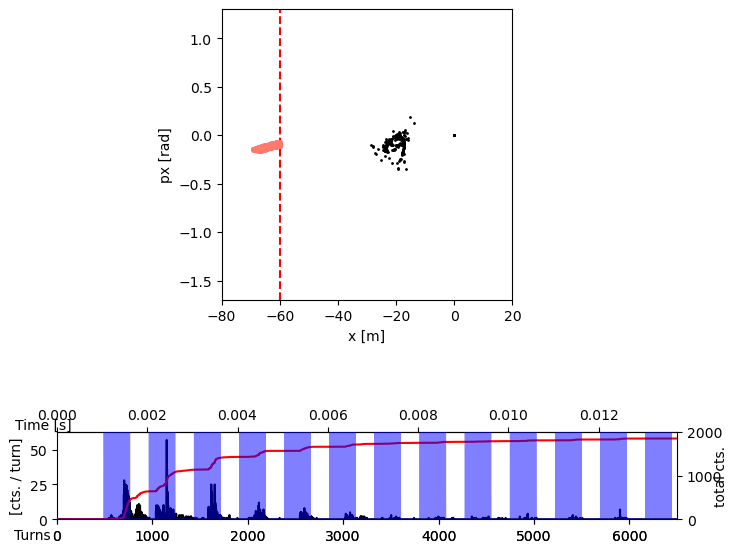

In [36]:
from matplotlib import animation

fig = plt.figure(figsize=(8, 6))

sf, sf2 = fig.subfigures(2, 1, height_ratios=[1, .3])
plt.subplots_adjust(bottom=0.25)

ax = sf.add_subplot(111, label='1')
ax2 = sf2.add_subplot(111, label='2', frame_on=True, axisbelow=True)
ax22 = sf2.add_subplot(111, label='22', frame_on=False, axisbelow=True, sharex=ax2)
ax3 = sf2.add_subplot(111, label='3', frame_on=False, axisbelow=True)

ax.set_ylim(-1.7, 1.3)
ax.set_xlim(-80, 20)
ax.set_xlabel("x [m]")
ax.set_ylabel("px [rad]")

ax.set_box_aspect(1)

# Phase Space
line, = ax.plot([], [], 'k.', markersize=2)
loss, = ax.plot([], [], 'r.', markersize=6, zorder=10, alpha=1)
lossf1, = ax.plot([], [], 'r.', markersize=5, zorder=9, alpha=.9)
lossf2, = ax.plot([], [], 'r.', markersize=4, zorder=8, alpha=.8)
loss_remain, = ax.plot([], [], marker='.', color="xkcd:salmon" , markersize=5, zorder=5, alpha=.5, linestyle='None')

# Extraction
instant, = ax2.plot([], [], 'k-')
ax2.set_ylim(0, max(turn_counts)*1.1)
ax2.set_xlim(0, N_TURN_CHIRP+N_TURN)

culm, = ax22.plot([], [], 'r-')
ax22.yaxis.tick_right()
ax22.yaxis.label_position = "right"
ax22.set_ylim(0, N_PART)
ax22.set_xlim(0, N_TURN_CHIRP+N_TURN)

ax2.set_xlabel("Turns", labelpad=10)
ax2.xaxis.set_label_coords(-0.04, -0.1)
ax222 = ax2.secondary_xaxis('top', functions=(lambda x: x/FREV, lambda x: x/FREV))
ax222.set_ylabel("Time [s]", rotation=0, labelpad=10)
ax2.set_ylabel("[cts. / turn]")
ax22.set_ylabel("total cts.")

# Chirp signal
chirp_duration = N_TURN_CHIRP/FREV
samples_for_chirp = chirp_duration*EXCITER_SAMPLING_FREQ
samples_to_extend = int(samples_for_chirp)
quad_collapse_duration = N_TURN/FREV
samples_for_quad_collapse = quad_collapse_duration*EXCITER_SAMPLING_FREQ
quad_collapse_to_extend = int(samples_for_quad_collapse)

chirp, = ax3.plot([], [], 'b', zorder=1, alpha=.5)
ax3.set_xlim(0, chirp_duration+quad_collapse_duration)
ax3.set_ylim(0, 1)
ax3.get_xaxis().set_visible(False)
ax3.get_yaxis().set_visible(False)

sept = ax.axvline(SEPTA_X_MM, color='red', linestyle='--', label='Septa')
def init():
    line.set_data([], [])

    loss.set_data([], [])
    lossf1.set_data([], [])
    lossf2.set_data([], [])
    loss_remain.set_data([], [])

    instant.set_data([], [])
    culm.set_data([], [])
    chirp.set_data([], [])
    return line, instant, culm, loss, chirp
def animate(i):

    turn = N_TURN+(i*3)

    x = M_TO_MM*smh57_monitor.x.T[turn:turn+2]
    y = RAD_TO_MRAD*smh57_monitor.px.T[turn:turn+2]
    line.set_data(x, y)

    try: loss_x, loss_y = list(zip(*np.array(loss_list)[np.where(np.logical_and(turn <= np.array(loss_list)[:,0], np.array(loss_list)[:,0] <= turn+2))[0]][:,1]))
    except ValueError: loss_x, loss_y = [], []

    try: lossf1_x, lossf1_y = list(zip(*np.array(loss_list)[np.where(np.logical_and(turn-3 <= np.array(loss_list)[:,0], np.array(loss_list)[:,0] <= turn-1))[0]][:,1]))
    except ValueError: lossf1_x, lossf1_y = [], []

    try: lossf2_x, lossf2_y = list(zip(*np.array(loss_list)[np.where(np.logical_and(turn-6 <= np.array(loss_list)[:,0], np.array(loss_list)[:,0] <= turn-4))[0]][:,1]))
    except ValueError: lossf2_x, lossf2_y = [], []

    try: loss_remain_x, loss_remain_y = list(zip(*np.array(loss_list)[np.where(np.array(loss_list)[:,0] <= turn-7)[0]][:,1]))
    except ValueError: loss_remain_x, loss_remain_y = [], []

    loss.set_data(np.array(loss_x)*M_TO_MM, np.array(loss_y)*RAD_TO_MRAD)
    lossf1.set_data(np.array(lossf1_x)*M_TO_MM, np.array(lossf1_y)*RAD_TO_MRAD)
    lossf2.set_data(np.array(lossf2_x)*M_TO_MM, np.array(lossf2_y)*RAD_TO_MRAD)
    loss_remain.set_data(np.array(loss_remain_x)*M_TO_MM, np.array(loss_remain_y)*RAD_TO_MRAD)

    #sf.suptitle(f"Turn {turn}")

    instant_x = range(turn)
    instant_y = turn_counts[:turn]
    instant.set_data(instant_x, instant_y)

    culm_x = range(turn)
    culm_y = turn_culm[:turn]
    culm.set_data(culm_x, culm_y)

    chirp_x = np.linspace(0, chirp_duration+quad_collapse_duration, samples_to_extend+quad_collapse_to_extend)
    chirp_y = np.pad(np.pad(chirp_signal, pad_width=(0, samples_to_extend-len(chirp_signal)), mode='wrap'), pad_width=(quad_collapse_to_extend, 0), mode='constant', constant_values=0)
    chirp.set_data(chirp_x, chirp_y)
    
    return line, instant, culm, loss, chirp

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=int(N_TURN_CHIRP/3), interval=1, blit=True)
#                               frames=int(6), interval=1, blit=True)
anim.save(f'{DIR}/rfko.gif', 
          writer=animation.PillowWriter(fps=30),
          )

# Saving with Memmap or Parquet

DTypes = float64

In [34]:
# Particles
particles.to_pandas().to_parquet(f"{DIR}/particles.parquet")
# Loss per particle
loss_locations = np.array(loss_list)
loss_locations_mmap = np.memmap('loss_locations.npy', mode='w+', dtype='float64', shape=loss_locations.shape)
loss_locations_mmap[:] = loss_locations[:]
# Losses
extraction_np = np.array(list(zip(*sorted(Counter(particles.at_turn).items()))))
extraction_mmap = np.memmap('extraction.npy', mode='w+', dtype='float64', shape=extraction_np.shape)
extraction_mmap[:] = extraction_np[:]
# Sequence
mad.save(sequence = 'ps', file = f"{DIR}/sequence.seq")

/var/folders/q6/pm7mcbgn2m3cs67hqk4fvgf40000gn/T/ipykernel_45707/1759703547.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  loss_locations = np.array(loss_list)


ValueError: setting an array element with a sequence.

In [ ]:
constant_dict = {
    "distribution":
        {
            "rel_gamma": REL_GAMMA,
            "rel_beta": REL_BETA,
            "exn": exn,
            "eyn": eyn,
            "ex": ex,
            "ey": ey,
            "p": p,
            "momentum": momentum,
            "Brho": Brho,
            "DPP_FACTOR": DPP_FACTOR,
            "N_PART": N_PART,
        },
    "quad_collapse":
        {
            "TUNE_TARGET": TUNE_TARGET,
            "CHROMATICITY_TARGET": CHROMATICITY_TARGET,
            "N_TURN": N_TURN,
            "DETUNE_QUAD_KNL1": DETUNE_QUAD_KNL1,
        },
    "rfko":
        {
            "SEPTA": SEPTA,
            "EXCITER_SAMPLING_FREQ": EXCITER_SAMPLING_FREQ,
            "FREV": FREV,
            "CHIRP_START": CHIRP_START,
            "CHIRP_STOP": CHIRP_STOP,
            "CHIRP_INTERVAL": CHIRP_INTERVAL,
            "N_TURN_CHIRP": N_TURN_CHIRP,
            "SEPTA_X_MM": SEPTA_X_MM,
        },
}
# save to file
with open(f"{DIR}/constants.json", "w") as f:
    json.dump(constant_dict, f, indent=4)